<a href="https://colab.research.google.com/github/laurenneal/capstone-visual-neuroscience/blob/Dylan/Validation_Wrapper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install CaImAn - takes around 2 minutes

!git clone https://github.com/flatironinstitute/CaImAn.git
%cd '/content/CaImAn/'
!pip install -e .

# Install caiman dependencies (&> /dev/null will suppress the hundreds of printed lines in the output)
!pip install -r requirements.txt &> /dev/null

#import other dependencies
import cv2
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import imageio

#IMPORTANT! Newer versions of h5py will cause errors when saving results
!pip install h5py==2.10.0
import h5py

#Set up caiman
!python setup.py build_ext -i

#Other file setup
!python caimanmanager.py install --inplace

#Caiman imports
import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params
from caiman.utils.utils import download_demo
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
from caiman.summary_images import local_correlations_movie_offline
from scipy.ndimage import center_of_mass
from IPython.display import display, clear_output

Cloning into 'CaImAn'...
remote: Enumerating objects: 24954, done.
remote: Counting objects: 100% (889/889), done.
remote: Compressing objects: 100% (427/427), done.
remote: Total 24954 (delta 501), reused 796 (delta 444), pack-reused 24065
Receiving objects: 100% (24954/24954), 518.53 MiB | 25.93 MiB/s, done.
Resolving deltas: 100% (16714/16714), done.
Checking out files: 100% (317/317), done.
/content/CaImAn
Obtaining file:///content/CaImAn
  Running setup.py develop for caiman
     |████████████████████████████████| 2.9 MB 12.6 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
running build_ext
Installed /root/caiman_data


## Get paths to movie files and labelled ROI masks

In [ ]:
#get a list of our masks and a list of our stacks in the same order
from os import listdir
maskpath = '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs'
mask_filenames = [f for f in listdir(maskpath) if 'manualROIs' in f]
mask_filenames = sorted(mask_filenames)
mask_filenames

['210728_0_1_manualROIs_tm2_tm9_syt.mat',
 '210731_0_1_manualROIs_mix2_syt.mat',
 '210815_0_1_manualROIs_mix1_syt.mat',
 '211023_0_1_manualROIs_tm2_tm4_syt.mat',
 '211106_0_1_manualROIs_tm1_t5_syt.mat',
 '211106_1_1_manualROIs_tm4_t5_syt.mat']

In [ ]:
stack_indices = [x[:10] for x in mask_filenames] #get the index portion of the masks
stack_celltypes = [x[22:(len(x)-4)] for x in mask_filenames] #get the cell type descriptions

#create filenames in mat and h5, well only keep what exists
stack_filenames_h5 = ['CLEAN_' + stack_indices[x] + '_stackRaw_mc_' + stack_celltypes[x] \
                   + '_.h5' for x in range(len(mask_filenames))] #reconstruct filenames for the movies we have masks for
stack_filenames_mat = ['CLEAN_' + stack_indices[x] + '_stackRaw_mc_' + stack_celltypes[x] \
                   + '_.mat' for x in range(len(mask_filenames))] #reconstruct filenames for the movies we have masks for
stack_filenames = stack_filenames_h5 + stack_filenames_mat 
stack_filenames

['CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.h5',
 'CLEAN_210731_0_1_stackRaw_mc_mix2_syt_.h5',
 'CLEAN_210815_0_1_stackRaw_mc_mix1_syt_.h5',
 'CLEAN_211023_0_1_stackRaw_mc_tm2_tm4_syt_.h5',
 'CLEAN_211106_0_1_stackRaw_mc_tm1_t5_syt_.h5',
 'CLEAN_211106_1_1_stackRaw_mc_tm4_t5_syt_.h5',
 'CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.mat',
 'CLEAN_210731_0_1_stackRaw_mc_mix2_syt_.mat',
 'CLEAN_210815_0_1_stackRaw_mc_mix1_syt_.mat',
 'CLEAN_211023_0_1_stackRaw_mc_tm2_tm4_syt_.mat',
 'CLEAN_211106_0_1_stackRaw_mc_tm1_t5_syt_.mat',
 'CLEAN_211106_1_1_stackRaw_mc_tm4_t5_syt_.mat']

In [ ]:
#checking that files exist in our cleaned file
stackpath = '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED'
stackfiles = [f for f in listdir(stackpath) if f in stack_filenames]
stackfiles = sorted(stackfiles)
stackfiles

['CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.h5',
 'CLEAN_210731_0_1_stackRaw_mc_mix2_syt_.h5',
 'CLEAN_210815_0_1_stackRaw_mc_mix1_syt_.h5',
 'CLEAN_211023_0_1_stackRaw_mc_tm2_tm4_syt_.h5',
 'CLEAN_211106_0_1_stackRaw_mc_tm1_t5_syt_.h5',
 'CLEAN_211106_1_1_stackRaw_mc_tm4_t5_syt_.h5']

In [ ]:
#convert filenames back into paths
maskpaths = [maskpath+'/'+f for f in mask_filenames]
stackpaths = [stackpath+'/'+f for f in stackfiles]

In [ ]:
#join the lists into pairs of tuples
mask_stack_pairs = list(map(lambda x, y:[x,y], maskpaths, stackpaths))
mask_stack_pairs

[['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/210728_0_1_manualROIs_tm2_tm9_syt.mat',
  '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.h5'],
 ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/210731_0_1_manualROIs_mix2_syt.mat',
  '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210731_0_1_stackRaw_mc_mix2_syt_.h5'],
 ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/210815_0_1_manualROIs_mix1_syt.mat',
  '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210815_0_1_stackRaw_mc_mix1_syt_.h5'],
 ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/211023_0_1_manualROIs_tm2_tm4_syt.mat',
  '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_211023_0_1_stackRaw_mc_tm2_tm4_syt_.h5'],
 ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualRO

## Initialize parameters object with starter values

In [ ]:
#create parameters object
opts = params.CNMFParams()
#fname will be assigned in the loop
fnames = []
subfolder = 'stackRaw_mc'
opts.motion['var_name_hdf5'] = subfolder
opts.data['var_name_hdf5'] = subfolder

In [ ]:
# set initial values for extraction and evaluation
# most of these are specific to our data and will not need to be changed during optimization

# overall params about our data

fr = 20                 # approximate frame rate of data - CONFIRMED FPS
decay_time = .4         # length of transient - CONFIRMED APPROPRIATE FOR OUR INDICATOR GCaMP6f
dims = [128, 256]       # dimensions of the FOV in pixels - CONFIRMED
dxy = [.29, .29]        # resolution of 1 pixel in um - CONFIRMED BY CARL

opts.set('data', {'fnames': fnames,
                   'fr': fr,
                   'decay_time': decay_time,
                   'dims': dims,
                   'dxy': dxy
                  })


# params related to the temporal traces

p = 0                   # order of the autoregressive system - 0 from carl's code
fudge_factor = 1        # (default is 0.96; Carl's value = 1) -- bias correction factor for discrete time constants
ITER = 5                # (default is 2; Carl's value=5) -- block coordinate descent iterations
tnb = 1                  # temporal global background components - TUNE

opts.set('temporal', {'p': p,
                      'fudge_factor': fudge_factor,
                      'ITER': ITER,
                      'nb': tnb
                 })

# p is also set in the preprocessing step
opts.set('preprocess', {'p': p
                 })



# params related to the FOV and patches for parallel processing

is_patches = True      # flag for processing in patches or not - turn on or off

if is_patches:          # PROCESS IN PATCHES AND THEN COMBINE 
    rf = 25             # half size of each patch -not tuned
    stride = 5          # overlap between patches -not tuned
    K = 3               # number of components in each patch - TUNE - gets set later in INIT params
    p_patch = p

else:                   # PROCESS THE WHOLE FOV AT ONCE
    rf = None           # setting these parameters to None Not used
    stride = None       # will run CNMF on the whole FOV not used
    K = 10              # number of neurons expected (in the whole FOV) - not used

n_processes = 2         # Number of processes to run in parallel, 2 for 2 cores available in Colab

opts.set('patch', {'rf': rf,
                   'stride': stride,
                   'n_processes': n_processes
                  })   



# initialization params
ssub = 2                # spatial downsampling
tsub = 2                # temporal downsampling
ssub_B = 3              # background spatial downsampling
gSig = [0,0]            # radius (half-size) of average neurons (in pixels)
nb = 1                  # number of background components
method_init = 'sparse_nmf' #Caiman defaults to greedy_roi, carl's code uses sparse_nmf, but this runs MUCH slower

opts.set('init', {'K': K,            # declared above in patch params    
                   'gSig': gSig,      
                   'tsub': tsub,
                   'ssub': ssub,
                   'ssub_B': ssub_B,
                   'nb': nb,
                   'method_init': method_init
                  })

# parameters related to merging correlated ROIs
merge_thr = 0.96     # merging threshold, max correlation allowed - FOUND VIA TUNING

opts.set('merging', {'merge_thr': merge_thr
                            })


#set some spatial params
snb = 2                  # spatial global background components - TUNE

opts.set('spatial', {'nb': snb
                            })

# %% COMPONENT EVALUATION
# the components are evaluated in three ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
#   c) each shape passes a CNN based classifier (this will pick up only neurons
#           and filter out active processes)


#Not sure if these should be tuned or not

min_SNR = 2.5      # peak SNR for accepted components (if above this, acept)
SNR_lowest = 1         # minimum SNR for accepted components (if below this, reject)
rval_thr = 0.9     # space correlation threshold (if above this, accept)

use_cnn = True      # use the CNN classifier affects if 2 below params are used
min_cnn_thr = 0.9  # if cnn classifier predicts below this value, reject
cnn_lowest = 0.1   # neurons with cnn probability lower than this value are rejected

opts.set('quality', {'min_SNR': min_SNR,
                     'SNR_lowest': SNR_lowest,
                     'rval_thr': rval_thr,
                     'use_cnn': use_cnn,
                     'min_cnn_thr': min_cnn_thr,
                     'cnn_lowest': cnn_lowest})


#Manually assign subfolder variable
opts.motion['var_name_hdf5'] = subfolder
opts.data['var_name_hdf5'] = subfolder



#motion correction not used for our parameter tuning. Leaving these params here in case they get used in the future.

#%% First setup some parameters for data and motion correction
# dataset dependent parameters

# ADJUSTED FROM DEFAULTS TO CARL'S PARAMS ON 11/13 (not completely)

fr = 20             # imaging rate in frames per second
decay_time = 0.4    # length of a typical transient in seconds
dxy = (.29, .29)      # spatial resolution in x and y in (um per pixel)
# note the lower than usual spatial resolution here
max_shift_um = (12., 12.)       # maximum shift in um
patch_motion_um = (100., 100.)  # patch size for non-rigid correction in um

# motion correction parameters
pw_rigid = False       # flag to select rigid vs pw_rigid motion correction
# maximum allowed rigid shift in pixels
max_shifts = [int(a/b) for a, b in zip(max_shift_um, dxy)]
# start a new patch for pw-rigid motion correction every x pixels
strides = tuple([int(a/b) for a, b in zip(patch_motion_um, dxy)])
# overlap between pathes (size of patch in pixels: strides+overlaps)
overlaps = (24, 24)
# maximum deviation allowed for patch with respect to rigid shifts
max_deviation_rigid = 3

opts.set('motion', {
    'fnames': fnames,
    'fr': fr,
    'decay_time': decay_time,
    'dxy': dxy,
    'pw_rigid': pw_rigid,
    'max_shifts': max_shifts,
    'strides': strides,
    'overlaps': overlaps,
    'max_deviation_rigid': max_deviation_rigid,
    'border_nan': 'copy'
})

## Define pipeline function to run Caiman

In [ ]:
#Function to run cnmf, run seeded cnmf using masks, then return validation

def score_params(path_to_stack, path_to_masks, opts):
  import warnings
  warnings.simplefilter(action='ignore', category=FutureWarning)

  fnames = [path_to_stack]

  try:

    if 'dview' in locals():
      cm.stop_server(dview=dview)
    dview = cm.cluster.start_server(ncpus=2)

    #Run CNMF on raw stack using passed params
    print('starting cnmf')
    cnm = cnmf.CNMF(n_processes = 2, params=opts, dview=dview)
    print('cnm object initialized')
    cnm = cnm.fit_file(motion_correct = False, include_eval=True)
    print('cnmf and component evaluation completed')


    #Read in masks and reformat
    g = h5py.File(path_to_masks, 'r')

    #transpose the matrix and save to an array A
    mask_A = g['bwMaskStack'][:].T

    g.close()

    #rearrange the dimensions and show the new shape
    mask_A = mask_A.transpose(1,0,2)

    #reshape to 2D, first dimension is 128*256 (32768), 2nd dimension is the # of ROI's
    mask_A = mask_A.reshape((mask_A.shape[1]*mask_A.shape[0]), mask_A.shape[2])

    #convert the values from 0/1 to boolean False/True
    mask_A = np.array(mask_A, dtype=bool)
    print('mask read in and reformatted')

    #Seeded CNMF only works when seeded using mmap
    #import pathlib

    #read data from the original cnmf's mmap location
    Yr, dims, T = cm.load_memmap(cnm.mmap_file)

    # load frames in python format (T x X x Y)
    mov = np.reshape(Yr.T, [T] + list(dims), order='F')
    print('movie matrix loaded for seeded cnmf')


    #For seeded CNMF, need to adjust some params
    opts.patch['only_init'] = False
    opts.data['use_cnn'] = False

    print('params adjusted for seeded cnmf')
    
    #Initialize a new cnmf object and pass in our masks as the "Ain" param
    #"Ain" is A-in, meaning the A matrix holding the spatial footprints of the roi's
    cnm_seeded = cnmf.CNMF(n_processes = 2, params=opts, dview=dview, Ain=mask_A)
    print('seeded cnmf object initialized')
    cnm_seeded.fit(mov)
    print('seeded cnmf completed')

    #Try running register_ROIs and see what happens
    matched_ROIs1, matched_ROIs2, non_matched1, non_matched2, performance, A2 = cm.base.rois.register_ROIs(cnm_seeded.estimates.A, cnm.estimates.A, dims=dims)
    print('validation and scoring completed')

    #restore params for the next regular cnmf iteration
    opts.patch['only_init'] = True
    #opts.data['use_cnn'] = True

    cm.stop_server(dview=dview)


    #return performance metrics
    return {'matched_ROIs1': matched_ROIs1,
            'matched_ROIs2': matched_ROIs2,
            'non_matched1': non_matched1,
            'non_matched2': non_matched2, 
            'performance': performance,
            'A2': A2,
            'cnm_estimates': cnm.estimates,
            'seeded_cnm_estimates': cnm_seeded.estimates,
            'ROI_mask': mask_A,
            'Correlation_img': cnm.estimates.Cn}

  except:
    print('failed')
    cm.stop_server(dview=dview)

## Function to score all our stacks and return the avg f1

In [ ]:
#loop through the stack-mask pairs and print the accuracy results

def score_all_stacks(all_params):

  #print(all_params)

  K = all_params[0]
  gSig = [all_params[1], all_params[2]] #param passes one value, recreate [x,y] structure
  SNR_lowest = all_params[3]


  from statistics import mean

  #hard coded paths since these won't change for now, proceduralize later
  mask_stack_pairs = [['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/210728_0_1_manualROIs_tm2_tm9_syt.mat',
  '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.h5'],
 ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/210731_0_1_manualROIs_mix2_syt.mat',
  '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210731_0_1_stackRaw_mc_mix2_syt_.h5'],
 ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/210815_0_1_manualROIs_mix1_syt.mat',
  '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210815_0_1_stackRaw_mc_mix1_syt_.h5'],
 ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/211023_0_1_manualROIs_tm2_tm4_syt.mat',
  '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_211023_0_1_stackRaw_mc_tm2_tm4_syt_.h5'],
 ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/211106_0_1_manualROIs_tm1_t5_syt.mat',
  '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_211106_0_1_stackRaw_mc_tm1_t5_syt_.h5'],
 ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/211106_1_1_manualROIs_tm4_t5_syt.mat',
  '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_211106_1_1_stackRaw_mc_tm4_t5_syt_.h5']]


  #Assign params passed in by the wrapper function
  #opts.init['K'] = K
  #opts.init['gSig'] = gSig
  #opts.quality['SNR_lowest'] = SNR_lowest
  #opts.set('temporal', {'p': 0})

  #store precisions from each stack-mask pair for this iteration in a list, we'll return the average
  f1s = []

  results_dict = {}

  #this loop will run all stacks through caiman using a given set of parameters to get the accuracy
  for pair in mask_stack_pairs:
    path_to_stack = pair[1]
    path_to_masks = pair[0]

    #set fnames before calling caiman function
    opts.data['fnames'] = [path_to_stack]
    print(opts.data['fnames'])

    results = score_params(path_to_stack=path_to_stack, \
              path_to_masks=path_to_masks, \
              opts=opts)


    #store this stack-mask pair's precision
    #later handle some kind of logging to keep a dict of info returned
    f1s.append(results['performance']['precision'])

    results_dict[path_to_masks.split('/')[6][0:-4]] = results

    print(results['performance'])

  #return the mean precision for all mask-stack pairs
  #negative of the precision, so that the optimizer can minimize
  print(f1s)
  return results_dict



In [ ]:
# #loop through the stack-mask pairs and print the accuracy results

# #JORDAN'S
# def score_all_stacks(all_params):

#   print(all_params)

#   K = all_params[0]
#   nb = all_params[1]
#   merge_thresh = all_params[2]
#   gSig = [all_params[3], all_params[4]] #param passes one value, recreate [x,y] structure
#   SNR_lowest = all_params[5]


#   from statistics import mean

#   #hard coded paths since these won't change for now, proceduralize later
#   mask_stack_pairs = [['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/210728_0_1_manualROIs_tm2_tm9_syt.mat',
#   '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.h5'],
#  ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/210731_0_1_manualROIs_mix2_syt.mat',
#   '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210731_0_1_stackRaw_mc_mix2_syt_.h5'],
#  ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/210815_0_1_manualROIs_mix1_syt.mat',
#   '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210815_0_1_stackRaw_mc_mix1_syt_.h5'],
#  ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/211023_0_1_manualROIs_tm2_tm4_syt.mat',
#   '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_211023_0_1_stackRaw_mc_tm2_tm4_syt_.h5'],
#  ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/211106_0_1_manualROIs_tm1_t5_syt.mat',
#   '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_211106_0_1_stackRaw_mc_tm1_t5_syt_.h5'],
#  ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/211106_1_1_manualROIs_tm4_t5_syt.mat',
#   '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_211106_1_1_stackRaw_mc_tm4_t5_syt_.h5']]


#   #Assign params passed in by the wrapper function
#   opts.init['K'] = K
#   opts.init['nb'] = nb #nb gets assigned in three different dicts
#   opts.spatial['nb'] = nb
#   opts.temporal['nb'] = nb
#   opts.merging['merge_thresh'] = merge_thresh
#   opts.init['gSig'] = gSig
#   opts.quality['SNR_lowest'] = SNR_lowest #added after latest run

#   #store precisions from each stack-mask pair for this iteration in a list, we'll return the average
#   f1s = []

#   results_dict = {}

#   #this loop will run all stacks through caiman using a given set of parameters to get the accuracy
#   for pair in mask_stack_pairs:
#     path_to_stack = pair[1]
#     path_to_masks = pair[0]

#     #set fnames before calling caiman function
#     opts.data['fnames'] = [path_to_stack]
#     print(opts.data['fnames'])

#     results = score_params(path_to_stack=path_to_stack, \
#               path_to_masks=path_to_masks, \
#               opts=opts)


#     #store this stack-mask pair's precision
#     #later handle some kind of logging to keep a dict of info returned
#     f1s.append(results['performance']['f1_score'])

#     results_dict[path_to_masks.split('/')[6][0:-4]] = results

#     print(results['performance'])

#   #return the mean precision for all mask-stack pairs
#   #negative of the precision, so that the optimizer can minimize
#   print(f1s)
#   return results_dict



In [ ]:
# #loop through the stack-mask pairs and print the accuracy results

# #LAURENS
# def score_all_stacks(all_params):

#   print(all_params)

#   K = all_params[0]
#   nb = all_params[1]
#   merge_thresh = all_params[2]
#   gSig = [all_params[3], all_params[4]] #param passes one value, recreate [x,y] structure
#   SNR_lowest = all_params[5]


#   from statistics import mean

#   #hard coded paths since these won't change for now, proceduralize later
#   mask_stack_pairs = [['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/210728_0_1_manualROIs_tm2_tm9_syt.mat',
#   '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/210728_0/210728_0_1_stackRaw_pmc_tm2_tm9_syt_.mat']]


#   #Assign params passed in by the wrapper function
#   opts.init['K'] = K
#   opts.init['nb'] = nb #nb gets assigned in three different dicts
#   opts.spatial['nb'] = nb
#   opts.temporal['nb'] = nb
#   opts.merging['merge_thresh'] = merge_thresh
#   opts.init['gSig'] = gSig
#   opts.quality['SNR_lowest'] = SNR_lowest

#   #store precisions from each stack-mask pair for this iteration in a list, we'll return the average
#   f1s = []

#   results_dict = {}

#   #this loop will run all stacks through caiman using a given set of parameters to get the accuracy
#   for pair in mask_stack_pairs:
#     path_to_stack = pair[1]
#     path_to_masks = pair[0]

#     #set fnames before calling caiman function
#     opts.data['fnames'] = [path_to_stack]
#     print(opts.data['fnames'])

#     results = score_params(path_to_stack=path_to_stack, \
#               path_to_masks=path_to_masks, \
#               opts=opts)


#     #store this stack-mask pair's precision
#     #later handle some kind of logging to keep a dict of info returned
#     f1s.append(results['performance']['f1_score'])

#     results_dict[path_to_masks.split('/')[6][0:-4]] = results

#     print(results['performance'])

#   #return the mean precision for all mask-stack pairs
#   #negative of the precision, so that the optimizer can minimize
#   print(f1s)
#   return results_dict



## Bayesian Model Optimization

In [ ]:
# !pip install scikit-optimize
# import skopt
# from skopt.callbacks import CheckpointSaver
# from skopt.callbacks import DeltaYStopper
# from skopt.callbacks import DeadlineStopper
# from skopt import plots
# from skopt import load

In [ ]:
# #define the parameter space - this is the entirety of the space I want to explore and will take a long time to run

# #change params if needed

# #first round ran 2-8 K, found 8 so increase
# #ran 1-3 nb, found 1 
# #ran 85-90 merge thr, found 96 so setting as default
# #ran 5-15 gSig_wid, found 14 so increase
# #ran 2-10 gSig_hei, found 8 so increase window
# # failed to assign SNR_lowest during first good iteration

# SPACE = [
#         skopt.space.Integer(8, 20, name='K'), #number of ROIs to expect in the FOV
#         #skopt.space.Integer(0, 1, name='nb'), #measure of how much background noise to remove, minimum 2 but higher could remove ROIs
#         skopt.space.Integer(12, 25, name = 'gSig_wid'), #half-width of neurons - Supposedly the most important
#         skopt.space.Integer(4, 14, name = 'gSig_hei'), #half-height of neurons - Supposedly the most important
#         skopt.space.Real(.1, 2, name = 'SNR_lowest')] #Minimum SNR accepted for ROIs, (if below this, reject)

In [ ]:
# #saves a checkpoint every iteration to this filepath

# #CHANGE THIS PATH OR FILENAME BEFORE YOU RUN THIS - LEAVE THE EXTENSION AS .PKL
# checkpoint_saver = CheckpointSaver('../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/search_checkpoints_dh_attempt_5.pkl')

# #stopping criteria - stop if the 5 best iterations are within 1% of each other
# stopping_criteria = skopt.callbacks.DeltaYStopper(.01, n_best=10)

# #second criteria, stop after 11.5 hours if it hasn't stopped yet - takes time in seconds as argument
# mins = 11.5 * 60
# seconds = mins * 60
# stopping_criteria_2 = DeadlineStopper(total_time= seconds)


# # surrogate function, directly pass in parameter list, returns precision result directly
# #this is the function that the optimizer minimizes
# #score_all_stacks returns the precision * -1 so that the optimizer can minimize it
# def objective(parameters):
#     return score_all_stacks(parameters)

In [ ]:
# #load old checkpoints if we need - change path
# checkpoints = skopt.load('../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/search_checkpoints_dh_attempt_5.pkl')
# x0 = checkpoints.x_iters
# y0 = checkpoints.func_vals

In [ ]:
# #optimizer using objective function, parameter space, checkpointer, stopping criteria

# #change minimizer function if needed
# results = skopt.gbrt_minimize(objective, 
#                               SPACE, 
#                               x0=x0,     # already examined values for x from checkpoints
#                               y0=y0,     # observed values for x0 from checkpoints
#                               callback=[checkpoint_saver, stopping_criteria, stopping_criteria_2], 
#                               initial_point_generator = 'halton',
#                               n_random_starts=1,
#                               n_jobs = 2,
#                               verbose=True)

In [ ]:
# results

In [ ]:
# skopt.plots.plot_convergence(results)

In [ ]:
# skopt.plots.plot_objective(results)

## Old working code

In [ ]:
#tests score_all_stacks directly
dummy_in = [11, 5, 3, 1.5446345957880787]
results = score_all_stacks(dummy_in)

['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.h5']
Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
...............starting cnmf
cnm object initialized
USING MODEL:/root/caiman_data/model/cnn_model.json
1/1 [==============================] - 0s 124ms/step
....cnmf and component evaluation completed
mask read in and reformatted
movie matrix loaded for seeded cnmf
params adjusted for seeded cnmf
seeded cnmf object initialized
spatial support for each components given by the user
seeded cnmf completed
validation and scoring completed
{'recall': 0.0, 'precision': 0.0, 'accuracy': 0.0, 'f1_score': 0.0}
['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210731_0_1_stackRaw_mc_mix2_syt_.h5']
Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
..............starting cnmf
cnm object initialized
USING MODEL:/root/cai

UnboundLocalError: ignored

In [ ]:
keys = [x[0].split('/')[6][0:-4] for x in mask_stack_pairs]
#keys.remove('211106_0_1_manualROIs_tm1_t5_syt')
keys

In [ ]:
#visualize our results
import scipy.sparse as sparse
dims = [128,256]
for x in keys:  

  f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(18, 3), constrained_layout=True) 

  ax1.set_title('Original Correlation Image')
  ax1.imshow(np.reshape(results[x]['Correlation_img'], dims, order="F"), aspect='auto')

  roiimg = np.zeros((32768,1))
  for i in range(results[x]['cnm_estimates'].A.shape[1]):
    roiimg = roiimg+results[x]['cnm_estimates'].A[:,i]
  ax2.set_title('ROIs Extracted')
  ax2.imshow(np.reshape(roiimg, dims, order="F"), aspect='auto')

  M = results[x]['cnm_estimates'].A > 0
  img = np.zeros((32768,1))
  for i in range(M.shape[1]):
    img = img+M[:,i]

  ax3.set_title(f'Masks Extracted')
  ax3.imshow(np.reshape(img, dims, order="F"), aspect='auto')

  A_sparse = sparse.csc_matrix(results[x]['ROI_mask'])
  maskimg = np.zeros((32768,1))

  for i in range(A_sparse.shape[1]):
    maskimg = maskimg+A_sparse[:,i]

  ax4.set_title('ROI Truth Masks')
  ax4.imshow(np.reshape(maskimg, dims, order="F"), aspect='auto')

  overlay = roiimg+maskimg
  ax5.set_title('Overlay')
  ax5.imshow(np.reshape(overlay, dims, order="F"), aspect='auto')

  f.suptitle(f'Results for {x}: {results[x]["performance"]}')




In [ ]:
#tests score_params directly
opts.data['fnames'] = ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.h5']
score_params(path_to_masks='../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/210728_0_1_manualROIs_tm2_tm9_syt.mat', \
              path_to_stack='../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.h5', \
              opts=opts)

Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
...............starting cnmf
cnm object initialized
USING MODEL:/root/caiman_data/model/cnn_model.json
1/1 [==============================] - 0s 426ms/step
....cnmf and component evaluation completed
mask read in and reformatted
movie matrix loaded for seeded cnmf
params adjusted for seeded cnmf
seeded cnmf object initialized
spatial support for each components given by the user
seeded cnmf completed
validation and scoring completed


{'A2': <32768x10 sparse matrix of type '<class 'numpy.float64'>'
 	with 82393 stored elements in Compressed Sparse Column format>,
 'Correlation_img': array([[1.        , 1.        , 1.        , ..., 0.18953318, 0.2105732 ,
         0.20350972],
        [1.        , 1.        , 1.        , ..., 0.1620576 , 0.18993129,
         0.16884429],
        [1.        , 1.        , 1.        , ..., 0.19369724, 0.20731979,
         0.2121731 ],
        ...,
        [1.        , 1.        , 1.        , ..., 0.1797879 , 0.20600663,
         0.21988389],
        [1.        , 1.        , 1.        , ..., 0.15689481, 0.18545234,
         0.163464  ],
        [1.        , 1.        , 1.        , ..., 0.39999999, 0.4       ,
         0.33333333]]),
 'ROI_mask': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
      

In [ ]:
#tests cnm directly
opts.quality['use_cnn'] = False
opts.data['fnames'] = ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.h5']

if 'dview' in locals():
    cm.stop_server(dview=dview)
dview = cm.cluster.start_server(ncpus=2)
cnm = cnmf.CNMF(n_processes=2, params=opts, dview=dview)
cnm = cnm.fit_file(motion_correct = False, include_eval=True)
cm.stop_server(dview=dview)

cnm.estimates.A

....Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
..............

/content/CaImAn/caiman/base/rois.py:87: RuntimeWarning: invalid value encountered in true_divide
  cm = (Coor * A / A.sum(axis=0)).T
/usr/local/lib/python3.7/dist-packages/scipy/ndimage/measurements.py:1359: RuntimeWarning: invalid value encountered in double_scalars
  for dir in range(input.ndim)]


....

<32768x49 sparse matrix of type '<class 'numpy.float64'>'
	with 48693 stored elements in Compressed Sparse Column format>

In [ ]:
#tests masks and scoring directly 
fnames = ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.h5']
path_to_masks='../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/210728_0_1_manualROIs_tm2_tm9_syt.mat'
#Read in masks and reformat
g = h5py.File(path_to_masks, 'r')

#transpose the matrix and save to an array A
mask_A = g['bwMaskStack'][:].T

g.close()

#rearrange the dimensions and show the new shape
mask_A = mask_A.transpose(1,0,2)

#reshape to 2D, first dimension is 128*256 (32768), 2nd dimension is the # of ROI's
mask_A = mask_A.reshape((mask_A.shape[1]*mask_A.shape[0]), mask_A.shape[2])

#convert the values from 0/1 to boolean False/True
mask_A = np.array(mask_A, dtype=bool)
#print('mask read in and reformatted')

if 'dview' in locals():
    cm.stop_server(dview=dview)
dview = cm.cluster.start_server(ncpus=2)

#Seeded CNMF only works when seeded using mmap
#import pathlib

#create memmory map location for the original movie
#fname_new = cm.save_memmap(fnames, base_name=pathlib.Path(fnames[0]).stem + "_memmap_", order='C')

#read data from mmap location
Yr, dims, T = cm.load_memmap(cnm.mmap_file)

# load frames in python format (T x X x Y)
mov = np.reshape(Yr.T, [T] + list(dims), order='F')
#print('movie matrix loaded for seeded cnmf')


#For seeded CNMF, need to adjust some params
opts.patch['only_init'] = False
opts.patch['rf'] = None
opts.data['use_cnn'] = False

#print('params adjusted for seeded cnmf')
    
#Initialize a new cnmf object and pass in our masks as the "Ain" param
#"Ain" is A-in, meaning the A matrix holding the spatial footprints of the roi's
cnm_seeded = cnmf.CNMF(n_processes = 2, params=opts, dview=dview, Ain=mask_A)
#print('seeded cnmf object initialized')
cnm_seeded.fit(mov)
#print('seeded cnmf completed')

#Try running register_ROIs and see what happens
matched_ROIs1, matched_ROIs2, non_matched1, non_matched2, performance, A2 = cm.base.rois.register_ROIs(cnm_seeded.estimates.A, cnm.estimates.A, dims=dims)
#print('validation and scoring completed')

results = {'matched_ROIs1': matched_ROIs1,
            'matched_ROIs2': matched_ROIs2,
            'non_matched1': non_matched1,
            'non_matched2': non_matched2, 
            'performance': performance,
            'A2': A2,
            'cnm_estimates': cnm.estimates,
            'seeded_cnm_estimates': cnm_seeded.estimates,
            'ROI_mask': mask_A,
            'Correlation_img': cnm.estimates.Cn}

Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
..............spatial support for each components given by the user


Text(0.5, 0.98, "Results for 210728_0_1_stackRaw_mc_tm2_tm9_syt: {'recall': 0.16666666666666666, 'precision': 0.04081632653061224, 'accuracy': 0.03389830508474576, 'f1_score': 0.06557377049180328}")

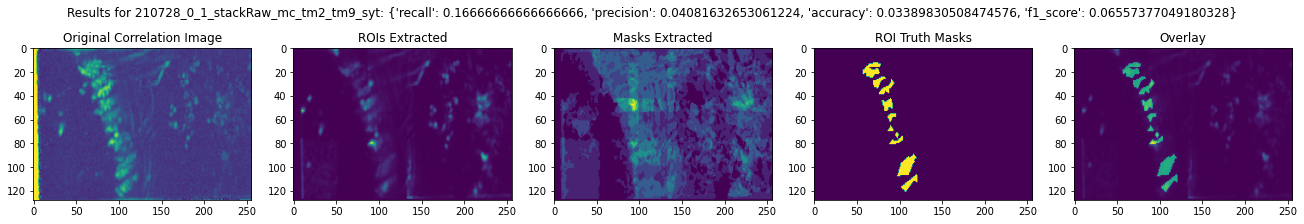

In [ ]:
import scipy.sparse as sparse
dims = [128,256]

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(18, 3), constrained_layout=True) 

ax1.set_title('Original Correlation Image')
ax1.imshow(np.reshape(results['Correlation_img'], dims, order="F"), aspect='auto')

roiimg = np.zeros((32768,1))
for i in range(results['cnm_estimates'].A.shape[1]):
  roiimg = roiimg+results['cnm_estimates'].A[:,i]
ax2.set_title('ROIs Extracted')
ax2.imshow(np.reshape(roiimg, dims, order="F"), aspect='auto')

M = results['cnm_estimates'].A > 0
img = np.zeros((32768,1))
for i in range(M.shape[1]):
  img = img+M[:,i]

ax3.set_title(f'Masks Extracted')
ax3.imshow(np.reshape(img, dims, order="F"), aspect='auto')

A_sparse = sparse.csc_matrix(results['ROI_mask'])
maskimg = np.zeros((32768,1))

for i in range(A_sparse.shape[1]):
  maskimg = maskimg+A_sparse[:,i]

ax4.set_title('ROI Truth Masks')
ax4.imshow(np.reshape(maskimg, dims, order="F"), aspect='auto')

overlay = roiimg+maskimg
ax5.set_title('Overlay')
ax5.imshow(np.reshape(overlay, dims, order="F"), aspect='auto')

f.suptitle(f'Results for 210728_0_1_stackRaw_mc_tm2_tm9_syt: {results["performance"]}')